In [16]:
#Libraries
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_log_error

In [37]:
#Import Data
data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Prelimaniry Analysis

In [26]:
#Columns and Column Values
real_valued_cols= ['LotFrontage', 'LotArea', 'YearBuilt',
                   'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                   'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                   '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                   'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
                   'FullBath', 'HalfBath', 'BedroomAbvGr', 
                   'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                   'GarageCars', 'GarageArea', 'WoodDeckSF',
                   'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                   'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold',
                   'YrSold']

categorical_valued_cols = ['MSSubClass', 'MSZoning', 'Street', 
                           'Alley', 'LotShape', 'LandContour', 
                           'Utilities', 'LotConfig', 'LandSlope',
                           'Neighborhood', 'Condition1', 
                           'Condition2', 'BldgType', 
                           'HouseStyle', 'RoofStyle', 'RoofMatl',
                           'Exterior1st', 'Exterior2nd',
                           'Foundation', 'BsmtFinType1',
                           'BsmtFinType2', 'Heating',
                           'Electrical', 'MiscFeature',
                           'SaleType', 'SaleCondition']

ordinal_valued_cols = ['OverallQual', 'OverallCond', 'ExterQual',
                       'ExterCond', 'BsmtQual', 'BsmtCond',
                       'BsmtExposure', 'HeatingQC', 'KitchenQual',
                       'Functional', 'FireplaceQu', 'GarageType',
                       'GarageFinish', 'GarageQual', 'GarageCond',
                       'PavedDrive', 'PoolQC', 'Fence']

boolean_valued_cols = ['CentralAir']

#Ordered from least to greatest
ordinal_cols_values = {'OverallQual': [1,2,3,4,5,6,7,8,9,10], 
                         'OverallCond': [1,2,3,4,5,6,7,8,9,10], 
                         'ExterQual': ['nan','Po', 'Fa', 'TA', 'Gd', 'Ex'],
                         'ExterCond': ['nan','Po', 'Fa', 'TA', 'Gd', 'Ex'],
                         'BsmtQual': ['nan', 'Fa','TA', 'Gd','Ex'],
                         'BsmtCond': ['nan', 'Po', 'Fa', 'TA', 'Gd'],
                         'BsmtExposure': ['nan', 'No', 'Mn', 'Av','Gd'],
                         'HeatingQC': ['nan','Po', 'Fa', 'TA', 'Gd', 'Ex'],
                         'KitchenQual': ['nan','Po', 'Fa', 'TA', 'Gd', 'Ex'],
                         'Functional': ['nan','Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
                         'FireplaceQu': ['nan', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                         'GarageType': ['nan', 'Detchd', 'CarPort', 'BuiltIn', 'Basment', 'Attchd', '2Types'],
                         'GarageFinish': ['nan', 'Unf', 'RFn', 'Fin'],
                         'GarageQual': ['nan', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                         'GarageCond': ['nan', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                         'PavedDrive': ['nan','N', 'P', 'Y'],
                         'PoolQC': ['nan', 'Fa', 'TA', 'Gd', 'Ex'],
                         'Fence': ['nan', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']}

cat_cols_values = {'MSSubClass':[60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75, 180,  40] , 
                      'MSZoning': ['nan','RL', 'RM', 'C (all)', 'FV', 'RH'], 
                      'Street': ['Pave', 'Grvl'], 
                      'Alley': ['nan', 'Grvl', 'Pave'], 
                      'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'], 
                      'LandContour': ['Lvl', 'Bnk', 'Low', 'HLS'], 
                      'Utilities': ['AllPub', 'NoSeWa'], 
                      'LotConfig': ['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], 
                      'LandSlope': ['Gtl', 'Mod', 'Sev'],
                      'Neighborhood': ['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
                                       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
                                       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
                                       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
                                       'Blueste'], 
                      'Condition1': ['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA','RRNe'], 
                      'Condition2': ['Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe'], 
                      'BldgType' : ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'], 
                      'HouseStyle': ['2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf','2.5Fin'], 
                      'RoofStyle': ['Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed'], 
                      'RoofMatl': ['CompShg', 'WdShngl', 'Metal', 'WdShake', 'Membran', 'Tar&Grv','Roll', 'ClyTile'],
                      'Exterior1st': ['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing','CemntBd', 
                                      'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
                                      'Stone', 'ImStucc', 'CBlock'], 
                      'Exterior2nd': ['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
                                       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
                                       'AsphShn', 'Stone', 'Other', 'CBlock'],
                      'Foundation': ['PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone'], 
                      'BsmtFinType1': ['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'nan', 'LwQ'],
                      'BsmtFinType2': ['Unf', 'BLQ', 'nan', 'ALQ', 'Rec', 'LwQ', 'GLQ'], 
                      'Heating':['GasA', 'GasW', 'Grav', 'Wall', 'OthW', 'Floor'],
                      'Electrical': ['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', 'nan'], 
                      'MiscFeature': ['nan', 'Shed', 'Gar2', 'Othr', 'TenC'],
                      'SaleType': ['WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth'], 
                      'SaleCondition': ['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family']} 

In [52]:
#Corrupted/Missing values for real_valued_cols
def corruptvaluesCNT(col):
    cnt = np.isinf(data[col]).values.sum()
    cnt += np.isnan(data[col]).values.sum()
    cnt +=  data[col][data[col] < 0].count()
    return cnt 

totalSum = 0
for i in real_valued_cols:
    totalSum += corruptvaluesCNT(i)
    
print(totalSum)


267


# Data Analysis/Insights

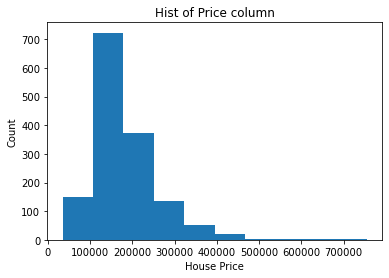

There are no negative values in the sales column:  True


In [4]:
#Y Histogram
y = data['SalePrice']
plt.hist(y)
plt.title('Hist of Price column')
plt.xlabel('House Price')
plt.ylabel('Count')
plt.show()

#Checking Regression Column
y = data[data['SalePrice']<0].shape
print("There are no negative values in the sales column: ", y[0]==0)

In [5]:
for c in real_valued_cols:
    print("Stats for column {}:".format(c))
    col = data[c]
    print("Mean: {}".format(col.mean()))
    print("Standard Deviation: {}".format(col.std()))
    print("Median: {}".format(col.median()))

Stats for column LotFrontage:
Mean: 70.04995836802665
Standard Deviation: 24.284751774483183
Median: 69.0
Stats for column LotArea:
Mean: 10516.828082191782
Standard Deviation: 9981.264932379147
Median: 9478.5
Stats for column YearBuilt:
Mean: 1971.267808219178
Standard Deviation: 30.202904042525265
Median: 1973.0
Stats for column YearRemodAdd:
Mean: 1984.8657534246574
Standard Deviation: 20.645406807709396
Median: 1994.0
Stats for column MasVnrArea:
Mean: 103.68526170798899
Standard Deviation: 181.06620658721818
Median: 0.0
Stats for column BsmtFinSF1:
Mean: 443.6397260273973
Standard Deviation: 456.09809084092456
Median: 383.5
Stats for column BsmtFinSF2:
Mean: 46.54931506849315
Standard Deviation: 161.31927280654057
Median: 0.0
Stats for column BsmtUnfSF:
Mean: 567.2404109589041
Standard Deviation: 441.8669552924342
Median: 477.5
Stats for column TotalBsmtSF:
Mean: 1057.4294520547944
Standard Deviation: 438.7053244594705
Median: 991.5
Stats for column 1stFlrSF:
Mean: 1162.6267123287

# PreProccessing: 
* Handle NaN's
* Change boolean values to Ints
* Hot encode categorical data
* Change Ordinal Values to integers 
* Concatenate all values together
* Standarization OF Data

In [6]:
#Handle Nan's
data.loc[:, data.columns.isin(real_valued_cols)] = data.loc[:, data.columns.isin(real_valued_cols)].replace(np.nan, 0, regex=True)
data = data.replace(np.nan,'nan',regex=True)

In [7]:
#Boolean
def booleanMap(x):
    if x == 'Y': 
        return 1 
    return 0

boolTemp = data.loc[:, data.columns.isin(boolean_valued_cols)].applymap(booleanMap)
print(boolTemp.shape)

(1460, 1)


In [8]:
#Categorical
def onehot(column=None, col=None):
  map = {}
  for j in range(len(col)):
    map[col[j]] = j

  lst = []
  for i in range(len(column)):
    array = np.zeros(len(col))
    if column.iloc[i] in map:
      array[map.get(column.iloc[i])] = 1
    lst.append(array)
  return np.array(lst)

catTemp = onehot(data['MSSubClass'], cat_cols_values['MSSubClass'])
for i in categorical_valued_cols[1:]:
    catTemp = np.concatenate((onehot(data[i], cat_cols_values[i]), catTemp), axis = 1)
print(catTemp.shape)

(1460, 196)


In [9]:
#Ordinial
def ordinialToInt(column=None, col=None):
    map = {}
    for j in range(len(col)):
        map[col[j]] = j
    
    temp = np.zeros((column.shape[0], 1))
        
    for i in range(len(column)):
        temp[i] = map[column[i]]
    return temp

ordTemp = ordinialToInt(data['OverallQual'], ordinal_cols_values['OverallQual'])
for i in ordinal_valued_cols[1:]:
    ordTemp = np.concatenate((ordTemp, ordinialToInt(data[i], ordinal_cols_values[i])), axis =1)
    
print(ordTemp.shape)

(1460, 18)


In [10]:
#Concatante all rows
finalDF = np.concatenate((data.loc[:, data.columns.isin(real_valued_cols)],
                          boolTemp,
                          catTemp,
                          ordTemp
                        ), axis = 1)
finalDF = pd.DataFrame(finalDF)

print(finalDF.shape)
print("Test to check nan and inf values: ", np.isnan(finalDF).values.sum()+ np.isinf(finalDF).values.sum())
finalDF.head()



(1460, 247)
Test to check nan and inf values:  0


,0,1,2,3,4,5,6,7,8,9,...,237,238,239,240,241,242,243,244,245,246
0,65.0,8450.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,...,4.0,8.0,0.0,5.0,2.0,3.0,3.0,3.0,0.0,0.0
1,80.0,9600.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,...,3.0,8.0,3.0,5.0,2.0,3.0,3.0,3.0,0.0,0.0
2,68.0,11250.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,...,4.0,8.0,3.0,5.0,2.0,3.0,3.0,3.0,0.0,0.0
3,60.0,9550.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,...,4.0,8.0,4.0,1.0,1.0,3.0,3.0,3.0,0.0,0.0
4,84.0,14260.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,...,4.0,8.0,3.0,5.0,2.0,3.0,3.0,3.0,0.0,0.0


In [11]:
#Standarization
df_scaled = finalDF
for column in df_scaled.columns:
    df_scaled[column] = (df_scaled[column] - df_scaled[column].mean()) / (df_scaled[column].std()+1)
finalDF = df_scaled

print(finalDF.shape)
print("Test to check nan and inf values: ", np.isnan(finalDF).values.sum()+ np.isinf(finalDF).values.sum())
finalDF.head()


(1460, 247)
Test to check nan and inf values:  0


,0,1,2,3,4,5,6,7,8,9,...,237,238,239,240,241,242,243,244,245,246
0,0.206837,-0.207050,1.016963,0.837787,0.511100,0.573969,-0.286776,-0.942135,-0.458101,-0.791116,...,0.293526,0.094873,-0.649385,0.506482,0.150170,0.11012,0.111123,0.096109,-0.010808,-0.256638
1,0.627426,-0.091846,0.151659,-0.409591,-0.567415,1.169028,-0.286776,-0.639561,0.465245,0.256389,...,-0.307523,0.094873,0.417897,0.506482,0.150170,0.11012,0.111123,0.096109,-0.010808,-0.256638
2,0.290955,0.073447,0.952866,0.791588,0.324011,0.092672,-0.286776,-0.300859,-0.312549,-0.625992,...,0.293526,0.094873,0.417897,0.506482,0.150170,0.11012,0.111123,0.096109,-0.010808,-0.256638
3,0.066641,-0.096855,-1.803288,-0.686786,-0.567415,-0.498011,-0.286776,-0.061509,-0.685526,-0.520209,...,0.293526,0.094873,0.773658,-0.857214,-0.378139,0.11012,0.111123,0.096109,-0.010808,-0.256638
4,0.739583,0.374982,0.920818,0.699190,1.358504,0.462396,-0.286776,-0.174410,0.199157,-0.045478,...,0.293526,0.094873,0.417897,0.506482,0.150170,0.11012,0.111123,0.096109,-0.010808,-0.256638


# Models:
* Linear Regression
* Random Forest
* GradientBoostingRegressor
* Logistic Regression

In [12]:
def kaggle_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

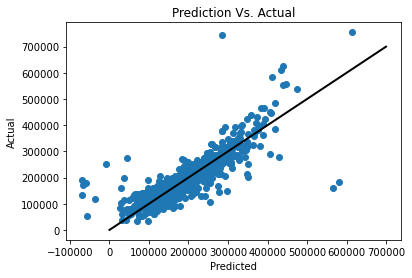

In [13]:
# Linear Regression
y = data['SalePrice']
x = finalDF
x = sm.add_constant(x)

# Model with Linear Regression
linModel = sm.OLS(y[:400], x[:400]).fit()

#Graph Predict Vs. Actual
pred = linModel.predict(x[400:])

plt.scatter(pred, y[400:]) 
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Prediction Vs. Actual")
plt.plot([0, 700000], [0,700000], color = 'black',  linewidth = 2)
plt.show()

In [30]:
#Model
kf = KFold()
Y = data['SalePrice']
X = finalDF
X = sm.add_constant(x)

model = LinearRegression()
error = 0

for train_idxs, test_idxs in kf.split(X):
    X_train = X.iloc[train_idxs]
    Y_train = Y.iloc[train_idxs]
    X_test = X.iloc[test_idxs]
    Y_test = Y.iloc[test_idxs]
    
    model.fit(X_train, Y_train)
    # use abs to prevent negatvie predictions - not sure why this is happening
    preds = np.abs(model.predict(X_test))
    print(preds.min())
    error += kaggle_error(Y_test, preds)
    print(error)
    
print("Average Root Log MSE: {}".format(error / kf.get_n_splits()))

12604.871826171875
2.884244155316671
4969.60498046875
6.0645718566375
470.62890625
8.891807453178133
4403.256103515625
11.286338742529374
53915.76953125
15.636364217372257
Average Root Log MSE: 3.1272728434744517


In [31]:
#Random Forest
kf = KFold()
Y = data['SalePrice']
X = finalDF
X = sm.add_constant(x)

#Model
model = RandomForestRegressor()
error = 0

for train_idxs, test_idxs in kf.split(X):
    X_train = X.iloc[train_idxs]
    Y_train = Y.iloc[train_idxs]
    X_test = X.iloc[test_idxs]
    Y_test = Y.iloc[test_idxs]
    
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    print(preds.min())
    error += kaggle_error(Y_test, preds)
    print(error)
    
print("Average Root Log MSE: {}".format(error / kf.get_n_splits()))

72722.22
0.13725918893444558
60799.1
0.2883961537983651
66902.11
0.4306294910212171
80320.87
0.5681340807936816
73060.66
0.7196060691637924
Average Root Log MSE: 0.1439212138327585


In [613]:
#GradientBoostingRegressor
y = data['SalePrice']
x = finalDF
x = sm.add_constant(x)

#Model
kf = KFold()
model = GradientBoostingRegressor()

error = 0

for train_idxs, test_idxs in kf.split(X):
    X_train = X.iloc[train_idxs]
    Y_train = Y.iloc[train_idxs]
    X_test = X.iloc[test_idxs]
    Y_test = Y.iloc[test_idxs]
    
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    print(preds.min())
    error += kaggle_error(Y_test, preds)
    print(error)
    
print("Average Root Log MSE: {}".format(error / kf.get_n_splits()))

71376.20847669142
0.12039032925842297
54737.75457832226
0.26463477594093043
44330.36781650643
0.4004844459288752
45690.84468933528
0.5198117105624179
59337.28796370255
0.6464113736167605
Average Root Log MSE: 0.1292822747233521


In [614]:
#LogisticRegression
y = data['SalePrice']
x = finalDF
x = sm.add_constant(x)

#Model
kf = KFold()
model = LogisticRegression()
error = 0

for train_idxs, test_idxs in kf.split(X):
    X_train = X.iloc[train_idxs]
    Y_train = Y.iloc[train_idxs]
    X_test = X.iloc[test_idxs]
    Y_test = Y.iloc[test_idxs]
    
    model.fit(X_train, Y_train)
    # use abs to prevent negatvie predictions - not sure why this is happening
    preds = np.abs(model.predict(X_test))
    print(preds.min())
    error += kaggle_error(Y_test, preds)
    print(error)
    
print("Average Root Log MSE: {}".format(error / kf.get_n_splits()))
    

/Users/PhilipAyoub/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


88000
0.269665492746474


/Users/PhilipAyoub/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


52000
0.5855070323087013


/Users/PhilipAyoub/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


86000
0.885121591771665


/Users/PhilipAyoub/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


55000
1.1889231225007504
88000
1.4827672211517948
Average Root Log MSE: 0.29655344423035895


/Users/PhilipAyoub/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Insights
As we can see above, the basic models perform rather well using one hot encodings for all features. Next steps: process features better to make data well conditioned to improve gradient boosting and handle ordinal values differently - use multi hot instead of one hot encodings or some other ideas. Want to get Root Log MSE down below 0.001 for good model.